# 2.2 Datasetの実装、 2.3 DataLoaderの実装

本ファイルでは、SSDなど物体検出アルゴリズム用のDatasetとDataLoaderを作成します。

VOC2012データセットを対象とします。


# 2.2 学習目標

1.	物体検出で使用するDatasetクラスを作成できるようになる
2.	SSDの学習時のデータオーギュメンテーションで、何をしているのかを理解する



# 2.3 学習目標

1.	物体検出で使用するDataLoaderクラスを作成できるようになる



# 事前準備


OpenCVのインストール

- pip install opencv-python

本書の指示に従い、VOC2010のデータセットをダウンロード

- http://host.robots.ox.ac.uk/pascal/VOC/voc2012/



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# パッケージのimport
from pathlib import Path
import random
# XMLをファイルやテキストから読み込んだり、加工したり、
# 保存したりするためのライブラリ
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

%matplotlib inline
%load_ext blackcellmagic

In [3]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# 画像データ、アノテーションデータへのファイルパスのリストを作成する

In [23]:
# from pytorch_advanced.c02_ssd.annotations import make_data_path_list
from pathlib import Path
from __future__ import annotations

In [16]:
# 学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する


def make_datapath_list(rootpath: str|Path) -> tuple[list[Path], list[Path], list[Path], list[Path]]:
    """
    データへのパスを格納したリストを作成する。

    Parameters
    ----------
    rootpath : str
        データフォルダへのパス

    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        データへのパスを格納したリスト
    """
    rootpath = Path(rootpath)

    # 画像ファイルとアノテーションファイルへのパスのテンプレートを作成
    img_dir = rootpath / "data" / "images"
    annot_dir = rootpath / "data" / "annotations"

    # 訓練と検証、それぞれのファイルのID（ファイル名）を取得する
    train_id_names = rootpath / "data" / "train_list.txt"
    val_id_names = rootpath / "data" / "val_list.txt"

    # 訓練データの画像ファイルとアノテーションファイルへのパスリストを作成
    train_ids = train_id_names.read_text().split("\n")
    val_ids = val_id_names.read_text().split("\n")
    train_img_list, train_anno_list = image_and_annotation_list(train_ids, img_dir, annot_dir)
    val_img_list, val_anno_list = image_and_annotation_list(val_ids, img_dir, annot_dir)

    return train_img_list, train_anno_list, val_img_list, val_anno_list

def image_and_annotation_list(file_ids: list[str], image_dir: Path, annot_dir: Path) -> tuple[list[Path], list[Path]]:
    return [image_dir / f"{f}.png" for f in file_ids], [annot_dir / f"{f}.json" for f in file_ids]
                               
                               

In [17]:
# ファイルパスのリストを作成
rootpath = Path("./")
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath
)

# 動作確認
print(train_img_list[0])
print(val_anno_list[0])

data/images/0000.png
data/annotations/0007.json


# xml形式のアノテーションデータをリストに変換する

In [6]:
from pytorch_advanced.c02_ssd.annotations import AnnoXML2List

In [21]:
!pip install pyserde

     |████████████████████████████████| 66 kB 2.8 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for stringcase: filename=stringcase-1.2.0-py3-none-any.whl size=3587 sha256=a9720773dcadbaea83af3cb3f595afd0db7a34c76cbf5642ef8e1bd6bcd00754
  Stored in directory: /home/jupyter/.cache/pip/wheels/04/0e/31/bf265c64f2a4d24516e9923f1f6293c3bcbcde75e0d80ab47a
Successfully built stringcase


In [68]:
# AnocciデータをPascal VOC形式に変換する

from dataclasses import dataclass
from pathlib import Path
from typing import Optional, List, Tuple
from serde import serde
from serde.json import from_json
import numpy as np


@serde
@dataclass
class ArrowPattern:
    axis_length: float
    head_length: float
    head_degree: float

@serde
@dataclass
class ArrowPosition:
    head: Tuple[float, float]
    dir: Tuple[float, float]

@serde
@dataclass
class Arrow:
    pattern: ArrowPattern
    position: ArrowPosition

@serde
@dataclass
class Dimension:
    p1: float
    p2: float

@serde
@dataclass
class Triangle:
    foot: Tuple[float, float]
    head: Tuple[float, float]

@serde
@dataclass
class TriangleRow:
    triangles: List[Triangle]

@serde
@dataclass
class OldJisSurfaceRoughness:
    nose: Tuple[float, float]
    foot: Tuple[float, float]
    head: str
    ra: Optional[float]

@serde
@dataclass
class NewJisSurfaceRoughness:
    nose: Tuple[float, float]
    foot: Tuple[float, float]
    head: str
    ra: Optional[float]

@serde
@dataclass
class LineRange:
    lower: float
    upper: float

@serde
@dataclass
class Box2d:
    x: LineRange
    y: LineRange

@serde
@dataclass
class DimensionBox:
    box2d: Box2d
    box_type: str


@serde
@dataclass
class Anocci:
    image_dimensions: Tuple[int, int]
    arrows: List[Arrow]
    dimensions: List[Dimension]
    dimension_boxes: List[DimensionBox]
    triangle_rows: List[TriangleRow]
    old_jis_surface_roughnesses: List[OldJisSurfaceRoughness]
    new_jis_surface_roughnesses: List[NewJisSurfaceRoughness]
    object_views: List[Box2d]


def anocci_from_json(json_path: Path) -> Anocci:
    return from_json(Anocci, json_path.read_text())

def voc_from_anocci_json(json_path: Path) -> np.ndarray:
    anocci = anocci_from_json(json_path)
    width, height = anocci.image_dimensions
    object_view_label = 1
    # object_views = list(map(lambda o: [o.x.lower / width, o.y.lower / height, o.x.upper / width, o.y.upper / height, object_view_label], anocci.object_views))
    object_views = list(map(lambda o: [o.x.lower, o.y.lower, o.x.upper, o.y.upper, object_view_label], anocci.object_views))
    
    return np.array(object_views, dtype=np.float32)
    
    

In [69]:
voc_from_anocci_json(val_anno_list[0])

array([[1.1174506e+03, 1.2570345e+03, 1.3876288e+03, 1.8606667e+03,
        1.0000000e+00],
       [1.9691646e+03, 1.2550258e+03, 2.1479441e+03, 1.8616711e+03,
        1.0000000e+00],
       [2.7269097e+03, 1.2560062e+03, 2.9979214e+03, 1.8636559e+03,
        1.0000000e+00],
       [2.7273994e+03, 6.5453888e+02, 2.9968162e+03, 8.3493085e+02,
        1.0000000e+00]], dtype=float32)

In [70]:
# 動作確認　
voc_classes = ['object_view']

In [71]:
ind = 1
image_file_path = val_img_list[ind]
json_path = val_anno_list[ind]

In [72]:
voc_from_anocci_json(json_path)

array([[1.2300088e+03, 8.4375336e+02, 1.3673376e+03, 1.5948085e+03,
        1.0000000e+00],
       [2.5145803e+03, 8.4132275e+02, 3.7930754e+03, 1.5948085e+03,
        1.0000000e+00]], dtype=float32)

# 画像とアノテーションの前処理を行うクラスDataTransformを作成する

In [76]:
!pip install albumentations

     |████████████████████████████████| 102 kB 5.6 MB/s            
     |████████████████████████████████| 39.3 MB 25.8 MB/s            
     |████████████████████████████████| 701 kB 95.3 MB/s            
     |████████████████████████████████| 47.7 MB 126.2 MB/s            
     |████████████████████████████████| 13.8 MB 103.6 MB/s            
     |████████████████████████████████| 26.7 MB 111.5 MB/s            
     |████████████████████████████████| 178 kB 118.9 MB/s            
     |████████████████████████████████| 1.9 MB 114.4 MB/s            
     |████████████████████████████████| 3.3 MB 100.8 MB/s            
     |████████████████████████████████| 6.3 MB 91.1 MB/s            
     |████████████████████████████████| 306 kB 121.0 MB/s            


In [104]:
# フォルダ「utils」にあるdata_augumentation.pyからimport。
# 入力画像の前処理をするクラス
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans
import albumentations as A

class DataTransform():
    """
    画像とアノテーションの前処理クラス。訓練と推論で異なる動作をする。
    画像のサイズを300x300にする。
    学習時はデータオーギュメンテーションする。


    Attributes
    ----------
    input_size : int
        リサイズ先の画像の大きさ。
    color_mean : (B, G, R)
        各色チャネルの平均値。
    """

    def __init__(self, input_size, color_mean):
        """
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),  # intをfloat32に変換
                ToAbsoluteCoords(),  # アノテーションデータの規格化を戻す
                # PhotometricDistort(),  # 画像の色調などをランダムに変化
                # Expand(color_mean),  # 画像のキャンバスを広げる
                # RandomSampleCrop(),  # 画像内の部分をランダムに抜き出す
                # RandomMirror(),  # 画像を反転させる
                ToPercentCoords(),  # アノテーションデータを0-1に規格化
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ]),
            'val': Compose([
                ConvertFromInts(),  # intをfloatに変換
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ])
        }
        """
        self.data_transform = {
            'train': A.Compose([
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.2),
            ], bbox_params = A.BboxParams(format='pascal_voc', label_fields=['class_labels'])),
            'val': A.Compose([
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.2),
            ], bbox_params = A.BboxParams(format='pascal_voc', label_fields=['class_labels']))
        }
            
    def __call__(self, img, phase, boxes, labels):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        
        return self.data_transform[phase](image=img, bboxes=boxes, class_labels=labels) # labels


In [105]:
import cv2
from matplotlib import pyplot as plt

In [89]:
# 動作の確認

# 1. 画像読み込み
image_file_path = train_img_list[0]
img = cv2.imread(str(image_file_path))  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得|
height, width, channels

(3509, 4963, 3)

In [90]:
# 2. アノテーションをリストに
# transform_anno = Anno_xml2list(voc_classes)
anno_list = voc_from_anocci_json(train_anno_list[0])
anno_list

array([[1.0356504e+03, 1.0384969e+03, 3.5331040e+03, 2.2635410e+03,
        1.0000000e+00]], dtype=float32)

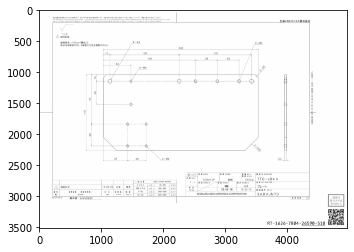

In [82]:
# 3. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [106]:
# 4. 前処理クラスの作成
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする
transform = DataTransform(input_size, color_mean)

In [109]:
# 5. train画像の表示
phase = "train"
_ = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])

In [111]:
img_transformed, boxes, labels = _["image"], _["bboxes"], _["class_labels"]

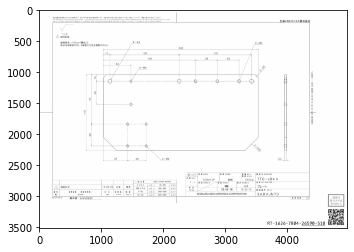

[(1035.650390625, 1038.4969482421875, 3533.10400390625, 2263.541015625)]
[1.0]


In [112]:
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()
print(boxes)
print(labels)

In [107]:




# 6. val画像の表示
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


# Datasetを作成する

In [9]:
# VOC2012のDatasetを作成する


class VOCDataset(data.Dataset):
    """
    VOC2012のDatasetを作成するクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    img_list : リスト
        画像のパスを格納したリスト
    anno_list : リスト
        アノテーションへのパスを格納したリスト
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    transform : object
        前処理クラスのインスタンス
    transform_anno : object
        xmlのアノテーションをリストに変換するインスタンス
    """

    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase  # train もしくは valを指定
        self.transform = transform  # 画像の変形
        self.transform_anno = transform_anno  # アノテーションデータをxmlからリストへ

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のテンソル形式のデータとアノテーションを取得
        '''
        im, gt, h, w = self.pull_item(index)
        return im, gt

    def pull_item(self, index):
        '''前処理をした画像のテンソル形式のデータ、アノテーション、画像の高さ、幅を取得する'''

        # 1. 画像読み込み
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
        height, width, channels = img.shape  # 画像のサイズを取得

        # 2. xml形式のアノテーション情報をリストに
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)

        # 3. 前処理を実施
        img, boxes, labels = self.transform(
            img, self.phase, anno_list[:, :4], anno_list[:, 4])

        # 色チャネルの順番がBGRになっているので、RGBに順番変更
        # さらに（高さ、幅、色チャネル）の順を（色チャネル、高さ、幅）に変換
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

        # BBoxとラベルをセットにしたnp.arrayを作成、変数名「gt」はground truth（答え）の略称
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

        return img, gt, height, width


In [10]:
# 動作確認
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))


# データの取り出し例
val_dataset.__getitem__(1)


(tensor([[[   0.9417,    6.1650,   11.1283,  ...,  -22.9082,  -13.2200,
             -9.4034],
          [   6.4367,    9.6600,   13.8283,  ...,  -21.4433,  -18.6500,
            -18.2033],
          [  10.8833,   13.5500,   16.7000,  ...,  -20.9917,  -24.5250,
            -25.1917],
          ...,
          [ -23.9501,  -14.9000,   -1.7583,  ..., -108.6083, -111.0000,
           -117.8083],
          [ -28.2816,  -20.1750,   -5.5633,  ..., -104.9934, -111.8350,
           -119.0000],
          [ -20.4766,  -21.0000,  -12.6334,  ..., -107.1685, -115.7800,
           -117.1100]],
 
         [[  25.9417,   30.1650,   35.1283,  ...,  -18.0766,  -14.7250,
            -11.8534],
          [  31.4367,   33.6600,   37.8283,  ...,  -13.5016,  -10.8250,
            -10.3783],
          [  35.7917,   37.5500,   40.7000,  ...,  -11.8417,  -13.0750,
            -14.0167],
          ...,
          [  -1.9501,    7.1000,   20.2417,  ..., -101.9083, -102.0000,
           -109.7167],
          [  -6.2

# DataLoaderを作成する

In [11]:
def od_collate_fn(batch):
    """
    Datasetから取り出すアノテーションデータのサイズが画像ごとに異なります。
    画像内の物体数が2個であれば(2, 5)というサイズですが、3個であれば（3, 5）など変化します。
    この変化に対応したDataLoaderを作成するために、
    カスタイマイズした、collate_fnを作成します。
    collate_fnは、PyTorchでリストからmini-batchを作成する関数です。
    ミニバッチ分の画像が並んでいるリスト変数batchに、
    ミニバッチ番号を指定する次元を先頭に1つ追加して、リストの形を変形します。
    """

    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])  # sample[0] は画像imgです
        targets.append(torch.FloatTensor(sample[1]))  # sample[1] はアノテーションgtです

    # imgsはミニバッチサイズのリストになっています
    # リストの要素はtorch.Size([3, 300, 300])です。
    # このリストをtorch.Size([batch_num, 3, 300, 300])のテンソルに変換します
    imgs = torch.stack(imgs, dim=0)

    # targetsはアノテーションデータの正解であるgtのリストです。
    # リストのサイズはミニバッチサイズです。
    # リストtargetsの要素は [n, 5] となっています。
    # nは画像ごとに異なり、画像内にある物体の数となります。
    # 5は [xmin, ymin, xmax, ymax, class_index] です

    return imgs, targets


In [12]:
# データローダーの作成

batch_size = 4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作の確認
batch_iterator = iter(dataloaders_dict["val"])  # イタレータに変換
images, targets = next(batch_iterator)  # 1番目の要素を取り出す
print(images.size())  # torch.Size([4, 3, 300, 300])
print(len(targets))
print(targets[1].size())  # ミニバッチのサイズのリスト、各要素は[n, 5]、nは物体数


torch.Size([4, 3, 300, 300])
4
torch.Size([2, 5])


In [13]:
print(train_dataset.__len__())
print(val_dataset.__len__())


5717
5823


以上